# Searching VEDA STAC API and Inspecting Catalogs with `intake`

This notebook shows how we can use `intake-stac` and `intake-xarray` to search, inspect and load data from VEDA STAC Search API.

### Environment Dependencies

These examples were developed on an SMCE Jupyterhub instance. A few requirements are needed to get things working:

0. Conda version `=>4.12.*` (so we can leverage the `mamba` resolver)

0. The following packages `conda install -y -c conda-forge intake-stac pystac-client rasterio --experimental-solver=libmamba`

### Authentication and Authorization to AWS S3 Catalogs

VEDA STAC catalogs point to AWS S3 data and auth is done through AWS Cognito. At a mininum you'll need:

* An AWS IAM account
* Adding yourself to the AWS Cognito user pool (and if cognito groups are involved then the cognito group as well)
* then temporary AWS session tokens can be created as shown below using the `pip3` `cognito-client` lib (https://pypi.org/project/cognito-client/)

In [3]:
import sys
!{sys.executable} -m pip install cognito_client

  Using cached cognito_client-0.0.1-py3-none-any.whl (5.3 kB)
  Using cached aws_cdk_lib-2.27.0-py3-none-any.whl (61.0 MB)
  Using cached aws_cdk.aws_cognito_identitypool_alpha-2.27.0a0-py3-none-any.whl (92 kB)
  Using cached black-22.3.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
  Using cached boto3_stubs-1.26.50-py3-none-any.whl (51 kB)
  Using cached boto3-1.24.15-py3-none-any.whl (132 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 5.2 MB/s eta 0:00:00
  Using cached jsii-1.73.0-py3-none-any.whl (570 kB)
  Using cached publication-0.0.3-py2.py3-none-any.whl (7.7 kB)
  Using cached pathspec-0.10.3-py3-none-any.whl (29 kB)
  Using cached s3transfer-0.6.0-py3-none-any.whl (79 kB)
  Using cached botocore-1.27.96-py3-none-any.whl (9.3 MB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)
  Using cached types_s3transfer-0.6.0.post5-py3-none-any.whl (17 kB)
  Using cached botocore_stubs-1.29.50-py3-none-any.whl (46 kB)
  Using cached mypy_boto

In [ ]:
import boto3
from cognito_client import CognitoClient
# client = CognitoClient(
#     client_id="<cognito-client-id>",
#     user_pool_id="<cognito-user-pool-id>",
#     identity_pool_id="<cognito-identity-pool-id>",
# )
client = CognitoClient(
    client_id="7ehkikrj119kja0pdmtse38vfr",
    user_pool_id="us-west-2_9mMSsMcxw",
    identity_pool_id="us-west-2:40f39c19-ab88-4d0b-85a3-3bad4eacbfc0",
)

_ = client.login()
creds = client.get_aws_credentials()

# this isn't needed, but it's an example showing that for temporary auth 
# sitautions `aws_session_token` along with the common two others are the most important
s3 = boto3.client(
    "s3",
    aws_access_key_id=creds["AccessKeyId"],
    aws_secret_access_key=creds["SecretKey"],
    aws_session_token=creds["SessionToken"],
)

## Searching VEDA STAC API

`intake-stac` doesn't come with it's own "search" client so we can use `pystac-client` or `sat-search` to do a search and then have `intake-stac` load the catalog/collections from the response payloads. Both search interfaces are very similar but we'll be using `pystac-client` for our search examples:

In [8]:
import intake
from pystac_client import Client
import rasterio as rio
from rasterio.plot import show

VEDA_STAC_API_URL = 'https://staging-stac.delta-backend.com/'

pystac_client = Client.open(VEDA_STAC_API_URL)                  
pystack_results = pystac_client.search(
    max_items=50,
)

### From `satsearch`||`pystac-client` search results to  `intake-stac`

Regardless of which search client we use `intake` requires data casted to `pystac.ItemCollection`(s) before we can inspect the catalog:


In [41]:
from pystac import ItemCollection

item_coll = ItemCollection(items=list(pystack_results.items()))
collection = intake.open_stac_item_collection(item_coll)

## Basic Inspection of Catalog/Collection(s) with `instake-stac`

In [79]:
# list the `features` of a STAC `FeatureCollection`
list(collection)

['SOR_SWE_tavg_ssp585_20770501_percChange.cog',
 'SOR_SWE_tavg_ssp585_20770501_median.cog',
 'SOR_SWE_tavg_ssp245_20770501_percChange.cog',
 'SOR_SWE_tavg_ssp245_20770501_median.cog',
 'NORW_SWE_tavg_ssp585_20770501_percChange.cog',
 'NORW_SWE_tavg_ssp585_20770501_median.cog',
 'NORW_SWE_tavg_ssp245_20770501_percChange.cog',
 'NORW_SWE_tavg_ssp245_20770501_median.cog',
 'NOR_SWE_tavg_ssp585_20770501_percChange.cog',
 'NOR_SWE_tavg_ssp585_20770501_median.cog',
 'NOR_SWE_tavg_ssp245_20770501_percChange.cog',
 'NOR_SWE_tavg_ssp245_20770501_median.cog',
 'MIR_SWE_tavg_ssp585_20770501_percChange.cog',
 'MIR_SWE_tavg_ssp585_20770501_median.cog',
 'MIR_SWE_tavg_ssp245_20770501_percChange.cog',
 'MIR_SWE_tavg_ssp245_20770501_median.cog',
 'CSCD_SWE_tavg_ssp585_20770501_percChange.cog',
 'CSCD_SWE_tavg_ssp585_20770501_median.cog',
 'CSCD_SWE_tavg_ssp245_20770501_percChange.cog',
 'CSCD_SWE_tavg_ssp245_20770501_median.cog',
 'SOR_SWE_tavg_ssp585_20770401_percChange.cog',
 'SOR_SWE_tavg_ssp585_20

In [39]:
# list the `assets` of a particular `FeatureCollection.<feature_id>`
list(collection['SOR_SWE_tavg_ssp585_20770501_median.cog'])

['cog_default']

In [48]:
# if the entries count is too high to `list` all of them in a notebook session you can "search" children of the `FeatureCollection`
for id, entry in collection.search('MIR').items():
    print(id)

MIR_SWE_tavg_ssp585_20770501_percChange.cog.cog_default
MIR_SWE_tavg_ssp585_20770501_percChange.cog
MIR_SWE_tavg_ssp585_20770501_median.cog.cog_default
MIR_SWE_tavg_ssp585_20770501_median.cog
MIR_SWE_tavg_ssp245_20770501_percChange.cog.cog_default
MIR_SWE_tavg_ssp245_20770501_percChange.cog
MIR_SWE_tavg_ssp245_20770501_median.cog.cog_default
MIR_SWE_tavg_ssp245_20770501_median.cog


In [44]:
# or inspect the metadata for a `Feature` outright as `yaml`
collection['SOR_SWE_tavg_ssp585_20770501_median.cog']

cog_default:
  args:
    chunks: {}
    urlpath: s3://veda-data-store-staging/EIS/snowProjections/SOR_SWE_tavg_ssp585_20770501_median.cog.tif
  description: Default COG Layer
  direct_access: allow
  driver: intake_xarray.raster.RasterIOSource
  metadata:
    description: Cloud optimized default layer to display on map
    href: s3://veda-data-store-staging/EIS/snowProjections/SOR_SWE_tavg_ssp585_20770501_median.cog.tif
    plots:
      geotiff:
        cmap: viridis
        data_aspect: 1
        dynamic: true
        frame_width: 500
        kind: image
        rasterize: true
        x: x
        y: y
    raster:bands:
    - data_type: float32
      histogram:
        buckets:
        - 5991.0
        - 3960.0
        - 3878.0
        - 4869.0
        - 6061.0
        - 4404.0
        - 2183.0
        - 743.0
        - 225.0
        - 39.0
        count: 11.0
        max: 848.5928344726562
        min: 1.0717778422986157e-05
      nodata: 0.0
      offset: 0.0
      sampling: area
 

In [45]:
# now walk from the `FeatureCollection` to a specific asset URL
collection['SOR_SWE_tavg_ssp585_20770501_median.cog']['cog_default'].metadata['href']

's3://veda-data-store-staging/EIS/snowProjections/SOR_SWE_tavg_ssp585_20770501_median.cog.tif'

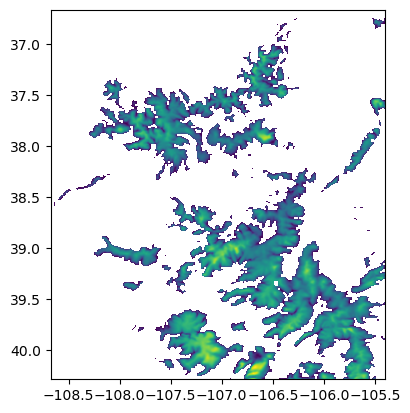

<AxesSubplot: >

In [80]:
# view this single cloud optimized geotiff source
cog = rio.open(collection['SOR_SWE_tavg_ssp585_20770501_median.cog']['cog_default'].metadata['href'])
show(cog)

### Loading Data Items with `intake-xarray`

After identifying an asset you want you can then load it into an `xarray.DataArray` using the `.to_dask()` function

In [71]:
import hvplot.xarray
da = collection['SOR_SWE_tavg_ssp585_20770501_median.cog']['cog_default'].to_dask()
da.hvplot.image()

:DynamicMap   [band]
   :Image   [x,y]   (value)

In [81]:
# or get all your `asset` hrefs in one fell swoop and load all of them
sources = [collection[feature]['cog_default'].metadata['href'] for feature in collection]
da_sources = intake.open_rasterio(sources, chunks={})
da = da_sources.to_dask()
da

<xarray.DataArray (concat_dim: 25, band: 1, y: 1337, x: 1483)>
dask.array<concatenate, shape=(25, 1, 1337, 1483), dtype=float32, chunksize=(1, 1, 1337, 1483), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 36.67 36.68 36.69 36.7 ... 49.05 49.05 49.06 49.06
  * x        (x) float64 -121.2 -121.2 -121.2 -121.2 ... -105.4 -105.4 -105.4
Dimensions without coordinates: concat_dim
Attributes:
    transform:           (0.010000000000005116, 0.0, -108.67498779296875, 0.0...
    crs:                 +init=epsg:4326
    res:                 (0.010000000000005116, 0.00999999999999803)
    is_tiled:            1
    nodatavals:          (-9999.0,)
    scales:              (1.0,)
    offsets:             (0.0,)
    descriptions:        ('band_data',)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

## Using STAC Browser to Help Build `pystack-client` Queries

VEDA comes with a nice interactive API browser (https://radiantearth.github.io/stac-browser/#/search/external/https://staging-stac.delta-backend.com) that we can use to help us build queries and crosswalk them to `pystack-client` queries

<div>
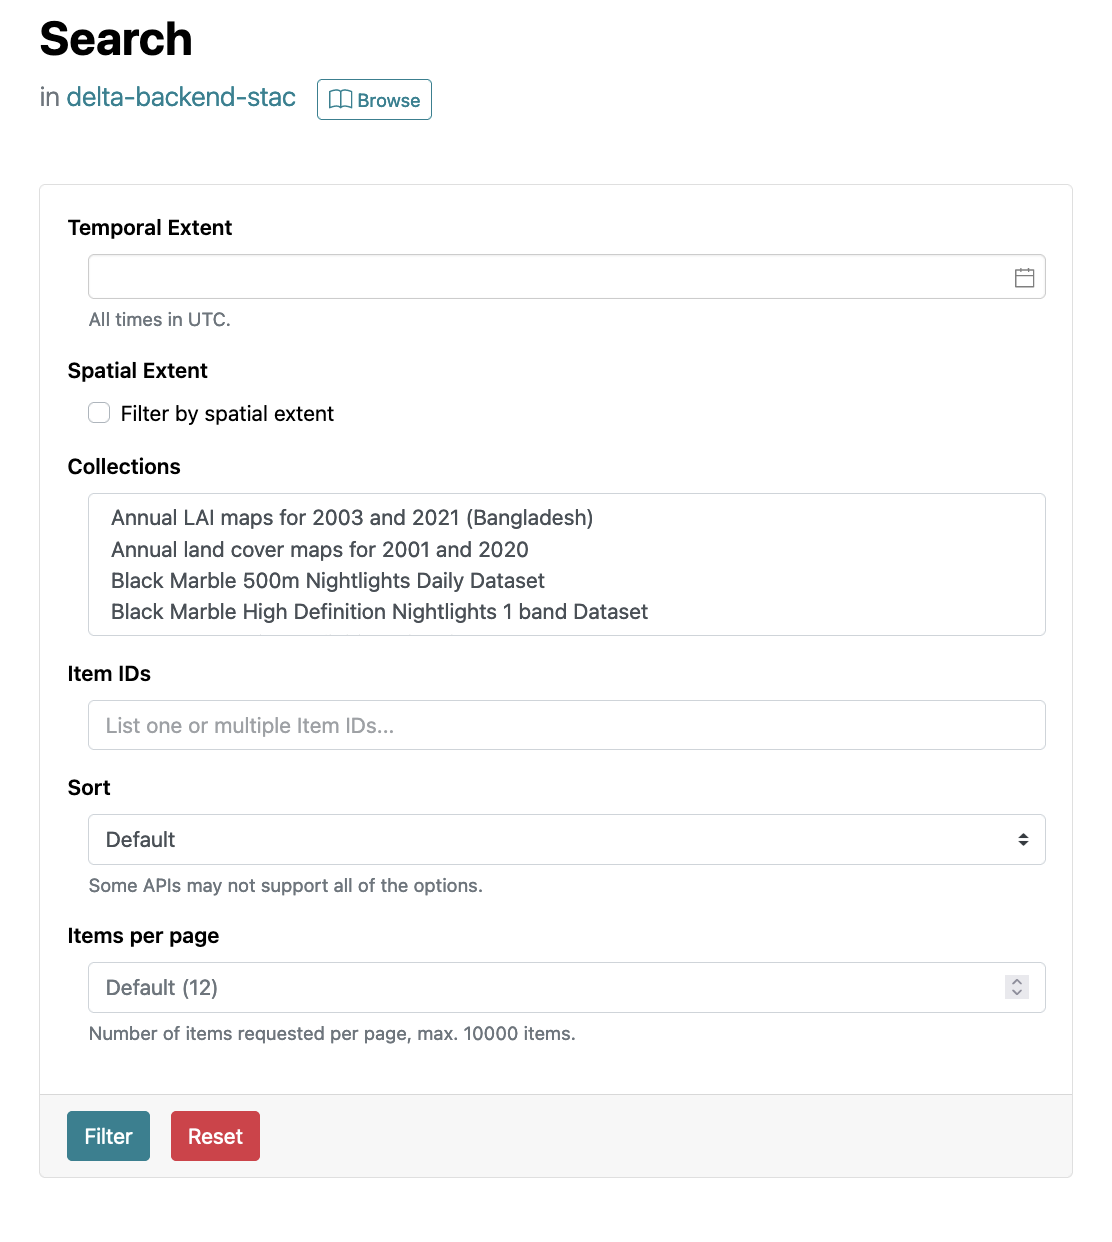
</div>

Let's walk through some examples!

### Filter by a Spatial Extent

In the STAC Browser add a spatial extent, a limit and change the default sort to be "Descending". Click "Filter" button to execute query 

<div>
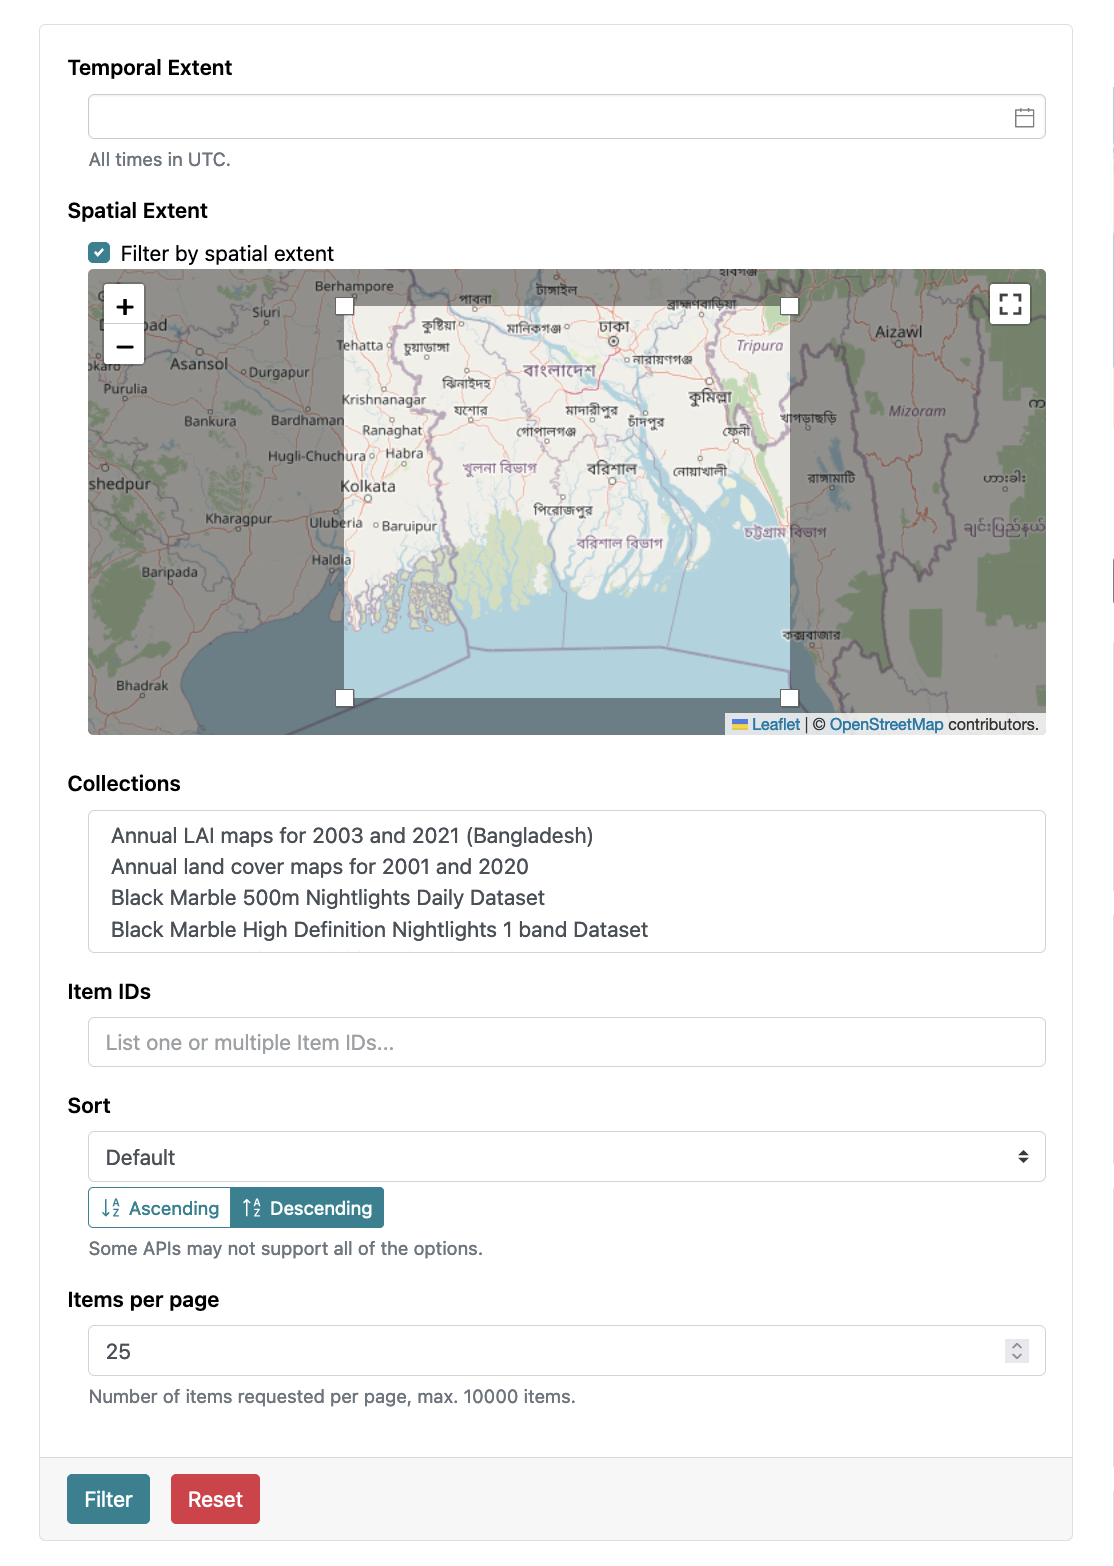
</div>

If you open up the browser's "Developer Tools" you should be able to find the XHR request to help you grok the spatial extent you can copy to into your `pystack-client` query:

<div>
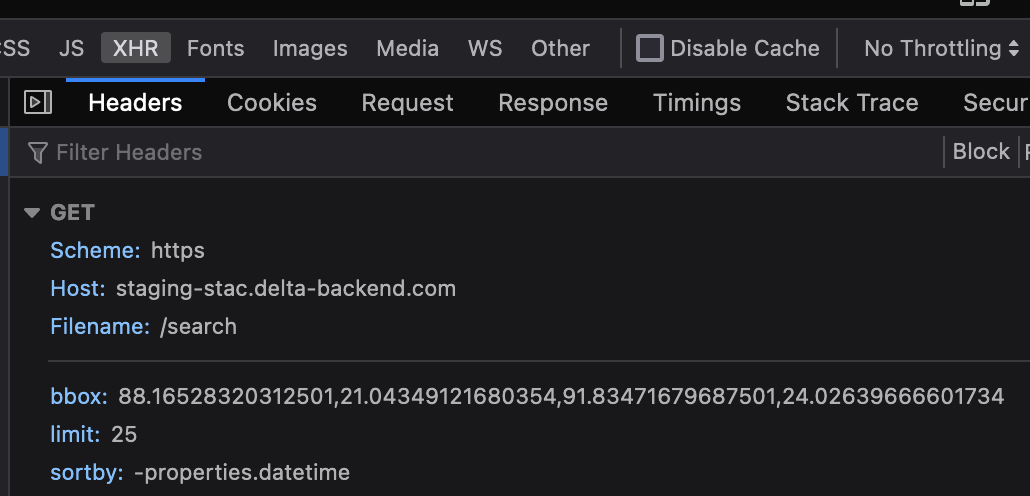
</div>

In [1]:
# here's the query in `pystack-client`
# https://pystac-client.readthedocs.io/en/latest/api.html#pystac_client.Client.search
pystac_client = Client.open(VEDA_STAC_API_URL)                  
pystack_results = pystac_client.search(
    max_items=15,  # this is the ceiling of results we want back, the UI doesn't give us this option so we use it just to make the query faster
    limit=25,  # we want all results but only 25 per page. so based on `max_items` all our results come back on the first page
    bbox=[88.16528320312501,21.04349121680354,91.83471679687501,24.02639666601734],
    sortby="-datetime"
)
item_coll = ItemCollection(items=list(pystack_results.items()))
collection = intake.open_stac_item_collection(item_coll)
list(collection)

NameError: name 'Client' is not defined

In [131]:
# change the sort to make sure it's working
# https://pystac-client.readthedocs.io/en/latest/api.html#pystac_client.Client.search
pystac_client = Client.open(VEDA_STAC_API_URL)                  
pystack_results = pystac_client.search(
    max_items=15,  # the UI doesn't give us this option so we use it just to make the query faster
    limit=25,  # so based on `max_items` we are retrieving one page of results
    bbox=[88.16528320312501,21.04349121680354,91.83471679687501,24.02639666601734],
    sortby="datetime"  # ascending
)
item_coll = ItemCollection(items=list(pystack_results.items()))
collection = intake.open_stac_item_collection(item_coll)
list(collection)

['SSH_2017_minus_1992.cog',
 'TREND_MEAN_TWS.cog',
 'MODIS_LC_2001_BD_v2.cog',
 'Anomaly_TWS_20020901.cog',
 'Anomaly_TWS_20020902.cog',
 'Anomaly_TWS_20020903.cog',
 'Anomaly_TWS_20020904.cog',
 'Anomaly_TWS_20020905.cog',
 'Anomaly_TWS_20020906.cog',
 'Anomaly_TWS_20020907.cog',
 'Anomaly_TWS_20020908.cog',
 'Anomaly_TWS_20020909.cog',
 'Anomaly_TWS_20020910.cog',
 'Anomaly_TWS_20020911.cog',
 'Anomaly_TWS_20020912.cog']

### Add a Temporal Extent

In the STAC Browser add a temporal extent (you can type in a range with the format `<yyyy>-<mm>-<dd> ~ <yyyy>-<mm>-<dd>`) or use the calendar widgets:

Also change the `sortby` to use `Title Ascending`
<div>
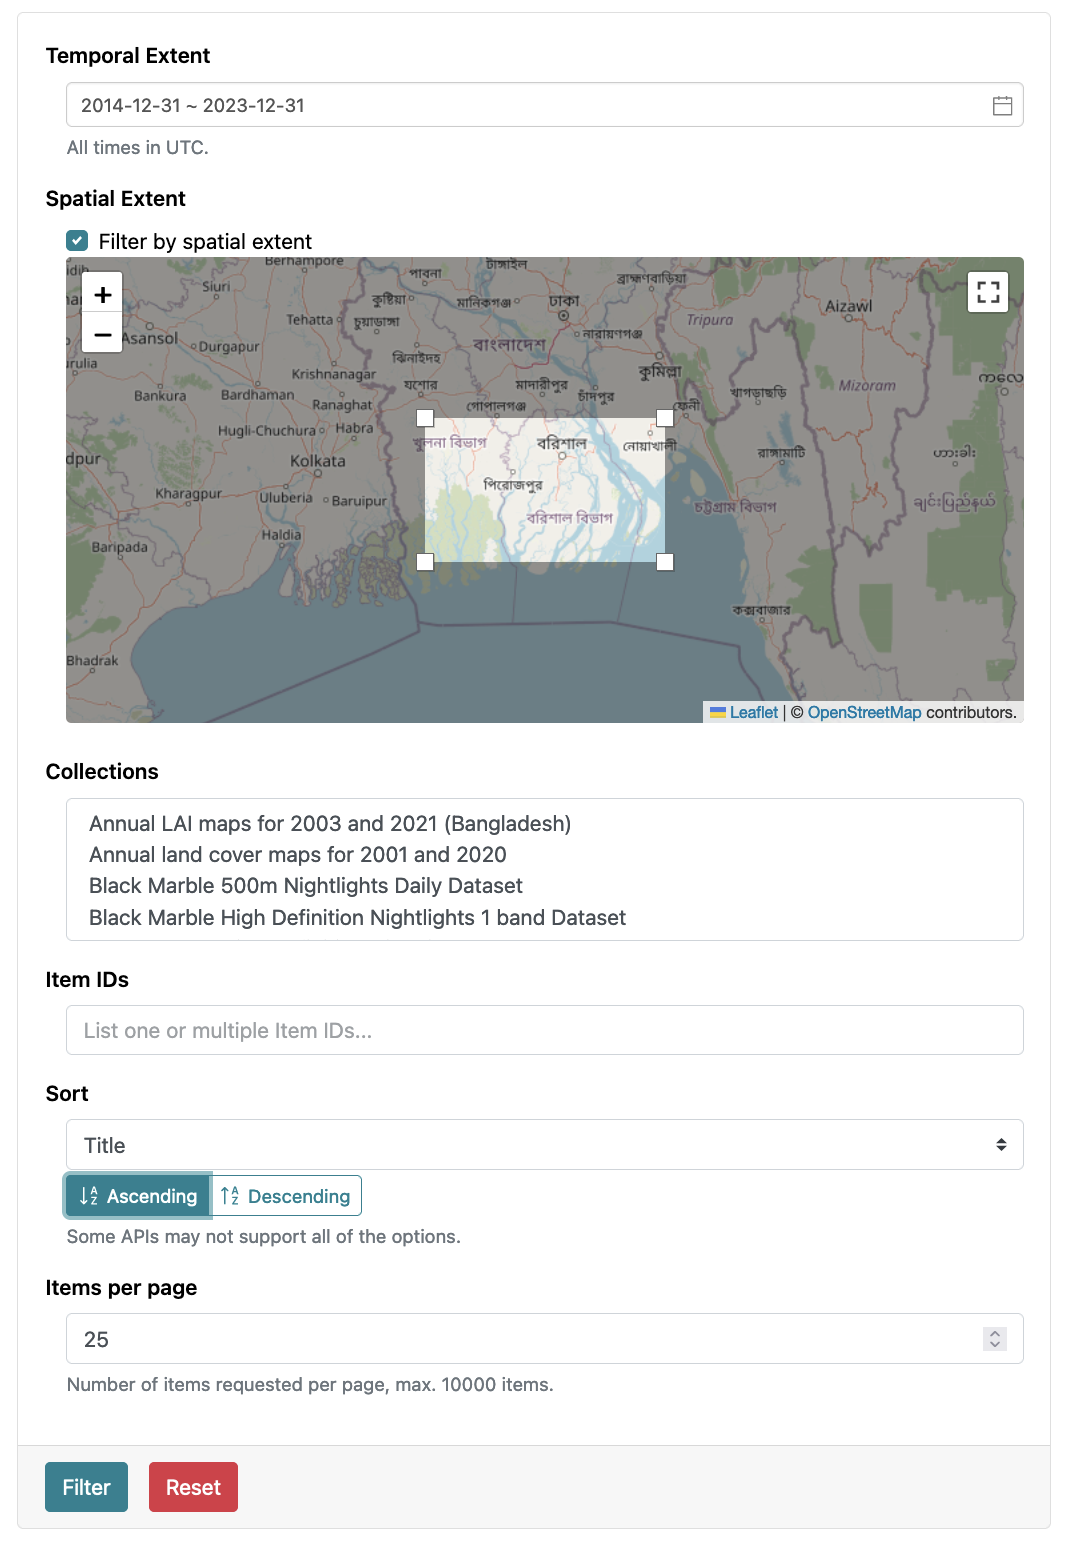
</div>

In [132]:
# here's the query in `pystack-client`
# https://pystac-client.readthedocs.io/en/latest/api.html#pystac_client.Client.search
pystac_client = Client.open(VEDA_STAC_API_URL)                  
pystack_results = pystac_client.search(
    max_items=15,  # the UI doesn't give us this option so we use it just to make the query faster
    limit=25,  # we want all results but only 25 per page
    datetime='2014-12-31T00:00:00.000Z/2023-12-31T00:00:00.000Z',
    bbox=[88.16528320312501,21.04349121680354,91.83471679687501,24.02639666601734],
    sortby="title"
)
item_coll = ItemCollection(items=list(pystack_results.items()))
collection = intake.open_stac_item_collection(item_coll)
list(collection)

['xco2_16day_mean._2022-02-13',
 'xco2_16day_mean._2022-02-12',
 'xco2_16day_mean._2022-02-11',
 'xco2_16day_mean._2022-02-10',
 'xco2_16day_mean._2022-02-09',
 'xco2_16day_mean._2022-02-08',
 'xco2_16day_mean._2022-02-07',
 'xco2_16day_mean._2022-02-06',
 'xco2_16day_mean._2022-02-05',
 'xco2_16day_mean._2022-02-04',
 'xco2_16day_mean._2022-02-03',
 'xco2_16day_mean._2022-02-02',
 'xco2_16day_mean._2022-02-01',
 'xco2_16day_mean._2022-01-31',
 'xco2_16day_mean._2022-01-30']

## Filter By Collection IDs

Or if we know a `FeatureCollection.id` that we care about we explicitly filter that way also

In [1]:
# here's the query in `pystack-client`
# https://pystac-client.readthedocs.io/en/latest/api.html#pystac_client.Client.search
pystac_client = Client.open(VEDA_STAC_API_URL)                  
pystack_results = pystac_client.search(
    max_items=15,  # the UI doesn't give us this option so we use it just to make the query faster
    limit=25,  # we want all results but only 25 per page
    collections="bangladesh-landcover-2001-2020",
    datetime='2015-01-01T00:00:00.000Z/2022-01-01T00:00:00.000Z',
    bbox=[88.16528320312501,21.04349121680354,91.83471679687501,24.02639666601734],
    sortby="title"
)
item_coll = ItemCollection(items=list(pystack_results.items()))
collection = intake.open_stac_item_collection(item_coll)
list(collection)

NameError: name 'Client' is not defined

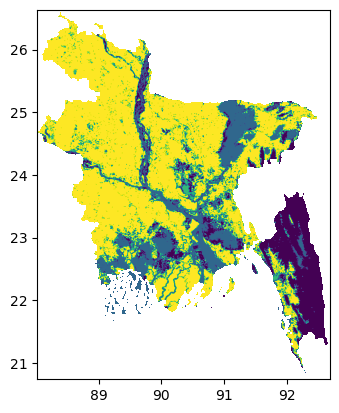

<AxesSubplot: >

In [135]:
cog = rio.open(collection['MODIS_LC_2020_BD.cog']['cog_default'].metadata['href'])
show(cog)